In [1]:
import pykat
import numpy as np

import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot
import matplotlib.pyplot as plt

import scipy
from scipy import signal

pykat.init_pykat_plotting(fmts=['svg'])

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
# input parameters
f_i = 1
f_e = 10000

In [69]:
### Create the baseline file

### Get the DARM Cavity Pole from the shot noise
%run LHO.py
base0= make_LHO()

base0 = aligo.make_kat("design_with_IMC_HAM2_FI_OMC", keepComments=True, preserveConstants=True)

#Sometimes this setup crashes so I just keep trying
result = None
while result is None:
    try:
        base0 = aligo.setup(base0)
        #base0.SRCL_lock.remove()
        base0.parse('''
        maxtem 2
        ''')
        print("Zero-ing locks")
        #base0.IFO.zero_locks() #Find phases to lock the IFO
        result = 1
    except:
        pass
        print("Ran into a pykat error, trying again")
    
base_tunings = base0.IFO.get_tunings()


Pykat parsing does not preserve inline comments. Moving inline
comments before command


Pykat parsing does not preserve inline comments. Moving inline
comments before command

Zero-ing locks


In [70]:
base_tunings

{'BS': 0.0,
 'ETMX': -0.0053834586466165405,
 'ETMY': 0.0053834586466165405,
 'ITMX': -0.002,
 'ITMY': 0.002,
 'PRM': 0.002,
 'SRM': -89.992,
 'keys': {'maxtem': 2, 'phase': 2}}

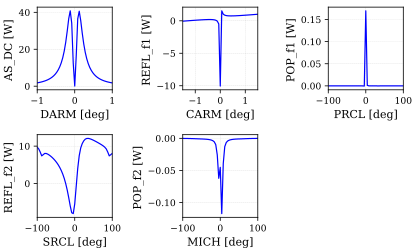

In [71]:
aligo.plot.error_signals(base0, xlimits=(-1, 1), steps=50)

In [46]:
CODE = """SRM_phis = []

cav_poles = []

ranges = np.arange(107,110,.1)
for i in range(len(ranges)):
        ### Get the DARM Cavity Pole from the shot noise
    %run LHO.py
    base0= make_LHO()

    #Sometimes this setup crashes so I just keep trying
    result = None
    while result is None:
        try:
            base0 = aligo.setup(base0)
            base0.undumpify()
            base0.ITMX.phi = 0
            base0.ETMX.phi = 0
            base0.ITMY.phi = 0
            base0.ETMY.phi = 0
            base0.SRM.phi  = ranges[i]
            base0.parse('''
            maxtem 2
            ''')
            print("Zero-ing locks")
            #base0.IFO.zero_locks() #Find phases to lock the IFO
            result = 1
            SRM_phis.append(ranges[i])
        except:
            pass
            print("Ran into a pykat error, trying again")
            
    kat0 = base0.deepcopy()
    kat0.parse(kat0.IFO.DARM.transfer())
    kat0.parse("qnoisedS NSR 1 $fs nAS")

    #remove the locks to increase speed
    kat0.removeBlock("locks", False)
    kat0.removeBlock("errsigs", False)

    out_shotnoise_cp = kat0.IFO.DARM_h.scan_f(linlog='log',lower=f_i,upper=f_e,steps=500)
    ### Find Cavity pole
    sn_dc = out_shotnoise_cp['NSR'][0]
    sn_pole = sn_dc/0.7071

    pole_index = np.where( out_shotnoise_cp['NSR'] > sn_pole )
    pole_index = pole_index[0].min()

    cav_pole = out_shotnoise_cp.x[pole_index]

    cav_poles.append(cav_pole)
    print(ranges[i],cav_pole)
    
    base_tunings = base0.IFO.get_tunings()"""
    

In [62]:
### Add some detectors
base0.parse('''
pd0 POP_DC nPOP
pd0 XARM_TRANS nETMX1
pd0 YARM_TRANS nETMY1
''')

In [63]:
kat0 = base0.deepcopy()
kat0.parse(kat0.IFO.DARM.transfer())
kat0.parse("qnoisedS NSR 1 $fs nAS")
kat0.IFO.fix_mirrors()

out_shotnoise_cp = kat0.IFO.DARM_h.scan_f(linlog='log',lower=f_i,upper=f_e,steps=50)

In [64]:
PR2_T = kat0.PR2.T.value
ETMX_T = kat0.ETMX.T.value
ETMY_T = kat0.ETMY.T.value

PRC_Buildup = out_shotnoise_cp['POP_DC'][0]/PR2_T
PRC_G = PRC_Buildup/kat0.L0.P.value
print("Power Recycling gain is "+str(round(PRC_G)))

XARM_Power =  out_shotnoise_cp['XARM_TRANS'][0]
YARM_Power =  out_shotnoise_cp['YARM_TRANS'][0]

print("X-ARM circulating power is "+str(round(XARM_Power)))
print("Y-ARM circulating power is "+str(round(YARM_Power)))

Power Recycling gain is 2.0
X-ARM circulating power is 1.0
Y-ARM circulating power is 1.0


In [65]:
### Find Cavity pole
sn_dc = out_shotnoise_cp['NSR'][0]
print(sn_dc)
sn_pole = sn_dc/0.7071

pole_index = np.where( out_shotnoise_cp['NSR'] > sn_pole )
pole_index = pole_index[0].min()

cav_pole = out_shotnoise_cp.x[pole_index]

print(cav_pole)

2.31214932882168e-20
2754.22870333536


In [54]:
out_shotnoise_cp['NSR']

array([2.31273409e-20, 2.31273370e-20, 2.31273315e-20, 2.31273235e-20,
       2.31273118e-20, 2.31272951e-20, 2.31272708e-20, 2.31272357e-20,
       2.31271850e-20, 2.31271117e-20, 2.31270058e-20, 2.31268527e-20,
       2.31266314e-20, 2.31263116e-20, 2.31258493e-20, 2.31251810e-20,
       2.31242150e-20, 2.31228189e-20, 2.31208008e-20, 2.31178839e-20,
       2.31136679e-20, 2.31075742e-20, 2.30987669e-20, 2.30860381e-20,
       2.30676427e-20, 2.30410601e-20, 2.30026509e-20, 2.29471627e-20,
       2.28670210e-20, 2.27513129e-20, 2.25843412e-20, 2.23435771e-20,
       2.19967999e-20, 2.14981737e-20, 2.07830559e-20, 1.97616262e-20,
       1.83125735e-20, 1.62824569e-20, 1.35158177e-20, 1.00563580e-20,
       7.44740363e-21, 1.10154200e-20, 2.12946214e-20, 3.64944903e-20,
       5.67722284e-20, 8.27499149e-20, 1.15076684e-19, 1.54201072e-19,
       1.99639969e-19, 2.22655734e-19, 3.47615781e-19])

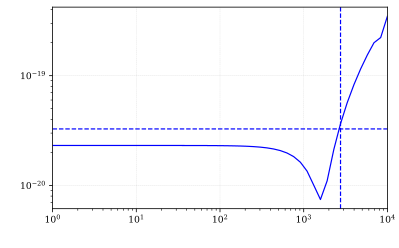

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.axhline(sn_pole,linestyle='--')
ax.axvline(cav_pole,linestyle='--')
ax.loglog(out_shotnoise_cp.x,abs(out_shotnoise_cp['NSR']))

ax.annotate('DARM Cavity Pole = '+str(round(cav_pole)), xy=(5, 1e-23))

ax.set_xlim(f_i,f_e)

plt.show()

In [26]:
### Get the sensitivity
kat = base0.deepcopy()
kat.IFO.suspend_mirrors_z()
kat.parse(kat.IFO.DARM.transfer())
kat.parse("qnoisedS NSR 1 $fs nAS")
out = kat.IFO.DARM_h.scan_f(linlog="log", lower=f_i, upper=f_e, steps=50)

In [27]:
### Load raw Darm data
raw_darm = np.loadtxt('20181106_DARM_PSD.txt')
raw_darm = raw_darm.transpose()
freq_darm = raw_darm[0]
data_darm = raw_darm[1]

# Make the zpk, z = 0.3, p= 30, k=1e-12
z_cal = -2*np.pi*np.array([30.,30.,30.,30.,30.,30.])
p_cal = -2*np.pi*np.array([0.3,0.3,0.3,0.3,0.3,0.3])

_ , zpk_cal = signal.freqresp((z_cal,p_cal,1.e-12), 2*np.pi*freq_darm)

asd_cal = np.abs(zpk_cal)

In [28]:
darm_cal = data_darm * np.abs(asd_cal)
sense = darm_cal/3994.5

In [29]:
"""#Search for sqz angle answer is something like 28.44 degrees

darm_sqz_data = []
sqz_angle = np.arange(-157.6,-157.2,0.02)

for i in range(len(sqz_angle)):
    kat_sqz = kat.deepcopy()
    #kat_sqz.IFO.fix_mirrors()
    kat_sqz.sqz.db = 3
    kat_sqz.sqz.angle = sqz_angle[i]
    kat_sqz.parse(kat.IFO.DARM.transfer())
    out_sqz = kat_sqz.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=50)
    darm_sqz_data.append(abs(out_sqz['NSR']))

ratio=[]

index_Hz = np.where(out.x < 500)
i_Hz = index_Hz[0][-1]

for i in range(len(darm_sqz_data)):
    app = darm_sqz_data[i][i_Hz]/abs(out['NSR'][i_Hz])
    ratio.append(app)

index = ratio.index(min(ratio))

print(sqz_angle[index])
####
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for i in range(len(sqz_angle)):
    ax.loglog(out.x,darm_sqz_data[i])
    
ax.loglog(out.x,abs(out['NSR']),'--',label='QM Limited sensitivity: No squeezing', linewidth=3)

ax.set_xlim(10,5000)

plt.legend()

plt.show()"""

'#Search for sqz angle answer is something like 28.44 degrees\n\ndarm_sqz_data = []\nsqz_angle = np.arange(-157.6,-157.2,0.02)\n\nfor i in range(len(sqz_angle)):\n    kat_sqz = kat.deepcopy()\n    #kat_sqz.IFO.fix_mirrors()\n    kat_sqz.sqz.db = 3\n    kat_sqz.sqz.angle = sqz_angle[i]\n    kat_sqz.parse(kat.IFO.DARM.transfer())\n    out_sqz = kat_sqz.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=50)\n    darm_sqz_data.append(abs(out_sqz[\'NSR\']))\n\nratio=[]\n\nindex_Hz = np.where(out.x < 500)\ni_Hz = index_Hz[0][-1]\n\nfor i in range(len(darm_sqz_data)):\n    app = darm_sqz_data[i][i_Hz]/abs(out[\'NSR\'][i_Hz])\n    ratio.append(app)\n\nindex = ratio.index(min(ratio))\n\nprint(sqz_angle[index])\n####\nfig = plt.figure(figsize=(10,6))\nax = fig.add_subplot(111)\n\nfor i in range(len(sqz_angle)):\n    ax.loglog(out.x,darm_sqz_data[i])\n    \nax.loglog(out.x,abs(out[\'NSR\']),\'--\',label=\'QM Limited sensitivity: No squeezing\', linewidth=3)\n\nax.set_xlim(10,5000)\n\nplt

In [30]:
kat_sqz = kat.deepcopy()

sqz_angle = -157.4

kat_sqz.sqz.db = 10

kat_sqz.sqz.angle = sqz_angle

out_sqz = kat_sqz.IFO.DARM_h.scan_f(linlog="log", lower=10, upper=5000, steps=50)

In [31]:
kat_sqz.IFO.get_tunings()

{'BS': 0.0,
 'ETMX': 0.6438986323618335,
 'ETMY': -0.6440144852503394,
 'ITMX': 0.647339194547713,
 'ITMY': -0.647339194547713,
 'PRM': -0.6444692424124941,
 'SRM': -73.85300000000001,
 'keys': {'maxtem': 0, 'phase': 2}}

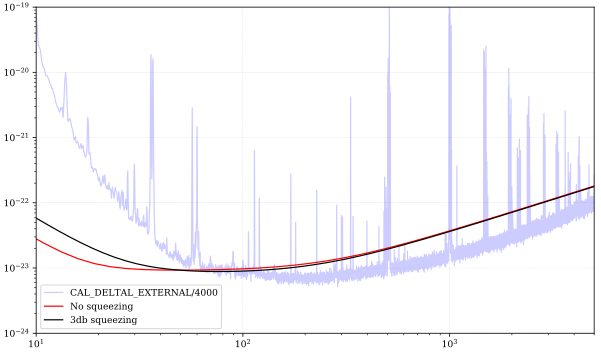

In [32]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.loglog(freq_darm,sense,alpha=0.2,label='CAL_DELTAL_EXTERNAL/4000')
ax.loglog(out.x,abs(out['NSR']), label='No squeezing')
ax.loglog(out_sqz.x,abs(out_sqz['NSR']), label='3db squeezing')

ax.set_xlim(10,5000)
ax.set_ylim(1e-24,1e-19)

plt.legend()
plt.show()

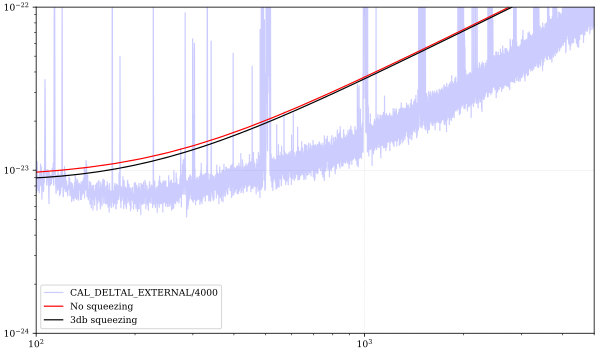

In [33]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)

ax.loglog(freq_darm,sense,alpha=0.2,label='CAL_DELTAL_EXTERNAL/4000')
ax.loglog(out.x,abs(out['NSR']), label='No squeezing')
ax.loglog(out_sqz.x,abs(out_sqz['NSR']), label='3db squeezing')

ax.set_xlim(100,5000)
ax.set_ylim(1e-24,1e-22)

plt.legend()
plt.show()